In [2]:
pip install numpy polars pandas matplotlib optuna scipy plotly seaborn lightgbm catboost xgboost scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

import re

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.impute import *

In [4]:
df_train = pd.read_csv('/content/train.csv')
df_test  = pd.read_csv('/content/test.csv')
df_sub = pd.read_csv('/content/sample_submission.csv')

In [5]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [7]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [8]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [9]:
df_train.shape,df_test.shape

((58645, 12), (39098, 11))

In [10]:
df_train.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


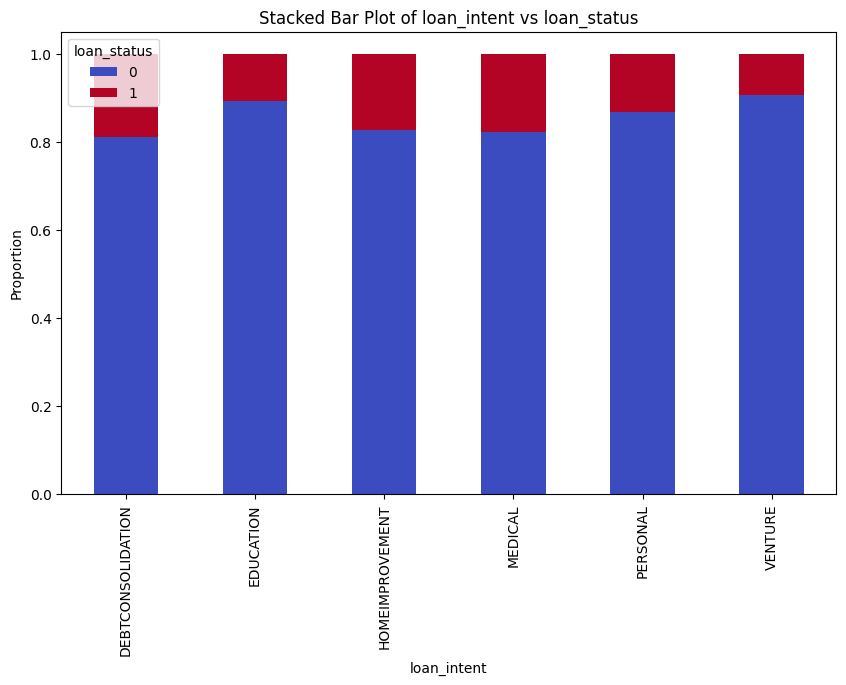

In [12]:
def stacked_bar_plot(df, feature, target='loan_status'):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
    plt.title(f'Stacked Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()
stacked_bar_plot(df_train, 'loan_intent')

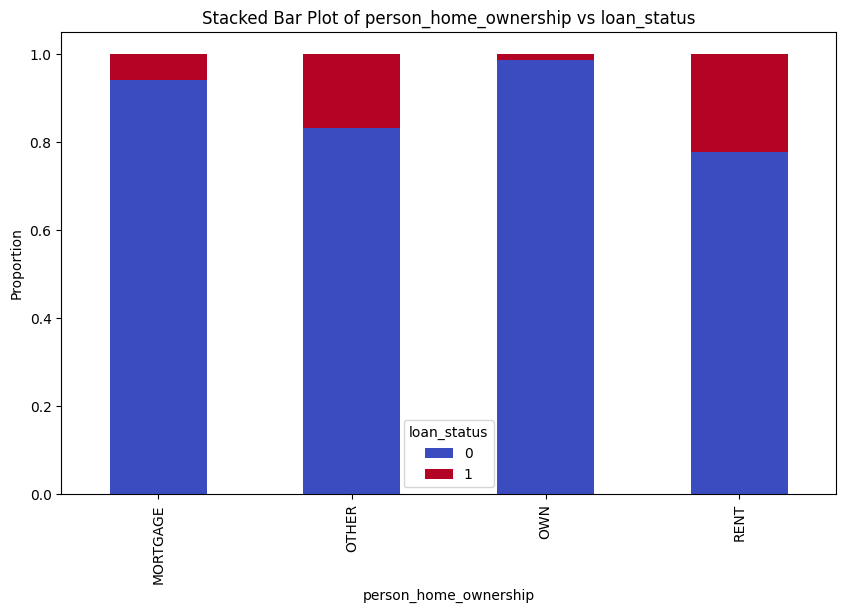

In [13]:
stacked_bar_plot(df_train, 'person_home_ownership')

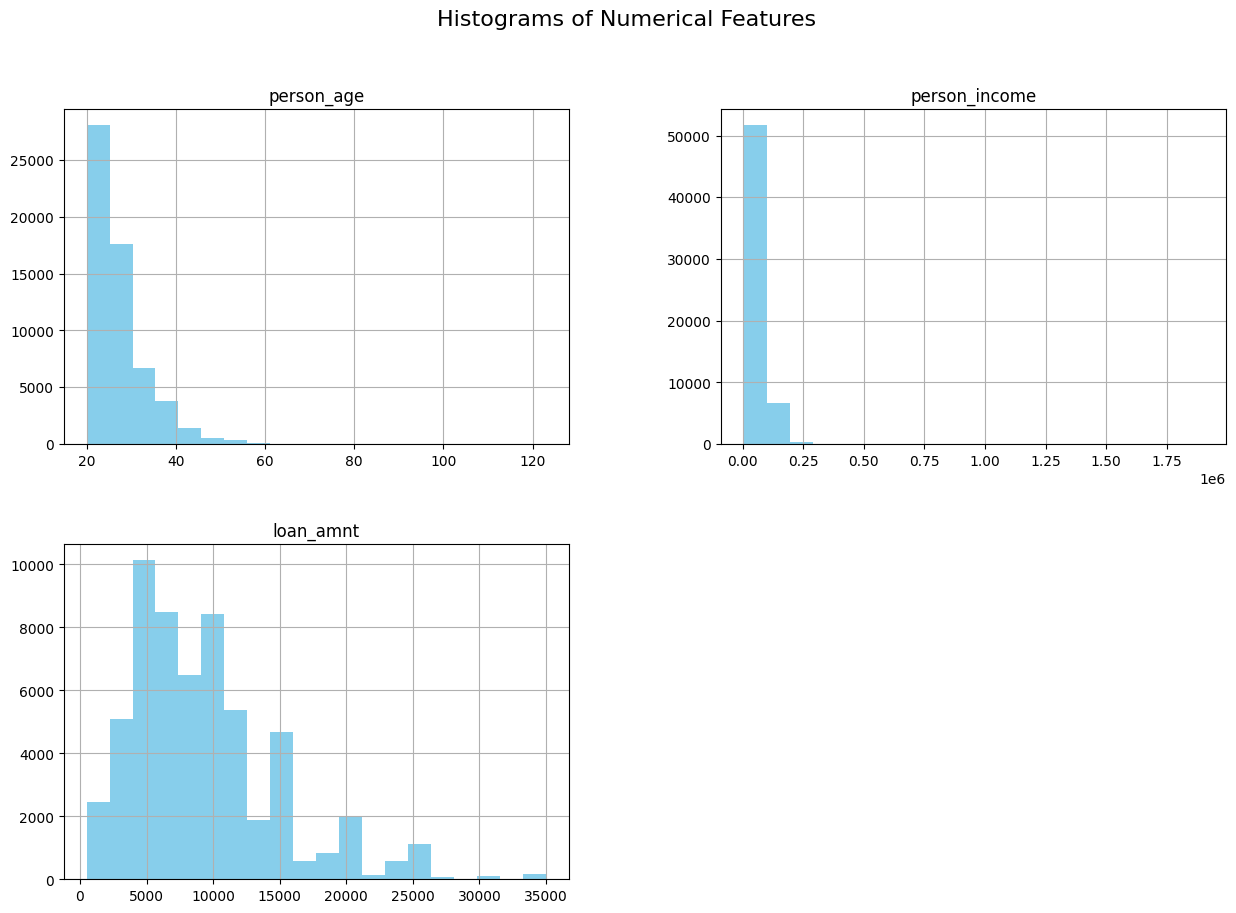

In [14]:
def plot_histograms(df, columns):
    df[columns].hist(bins=20, figsize=(15, 10), color='skyblue')
    plt.suptitle('Histograms of Numerical Features', fontsize=16)
    plt.show()

plot_histograms(df_train, ['person_age', 'person_income', 'loan_amnt'])

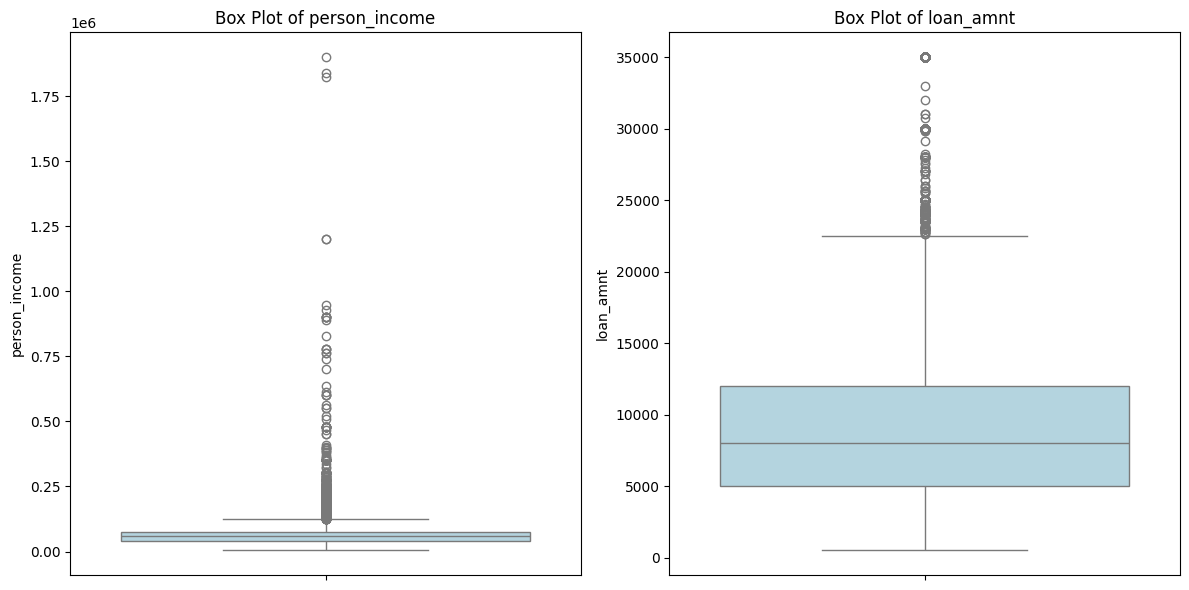

In [15]:
def plot_boxplots(df, columns):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y=df[col], color='lightblue')
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

plot_boxplots(df_train, ['person_income', 'loan_amnt'])

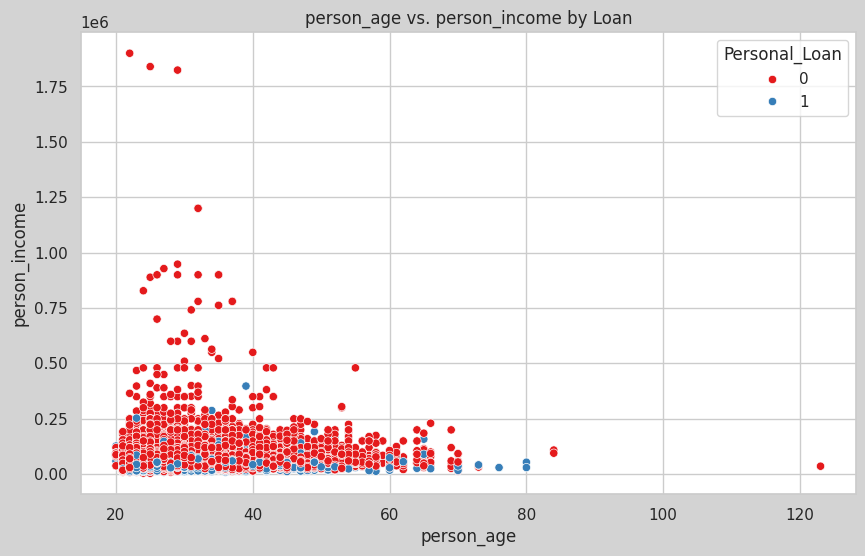

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='person_age', y='person_income', hue='loan_status', palette='Set1')
plt.title('person_age vs. person_income by Loan')
plt.xlabel('person_age')
plt.ylabel('person_income')
plt.legend(title='Personal_Loan')
plt.gcf().set_facecolor('lightgrey')
plt.show()

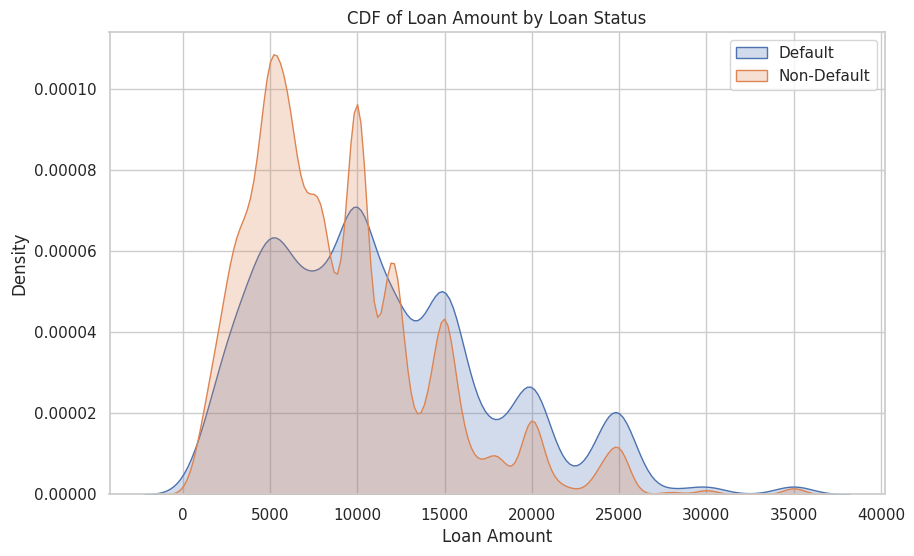

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train[df_train['loan_status'] == 1]['loan_amnt'], label='Default', fill=True)
sns.kdeplot(df_train[df_train['loan_status'] == 0]['loan_amnt'], label='Non-Default', fill=True)
plt.title('CDF of Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

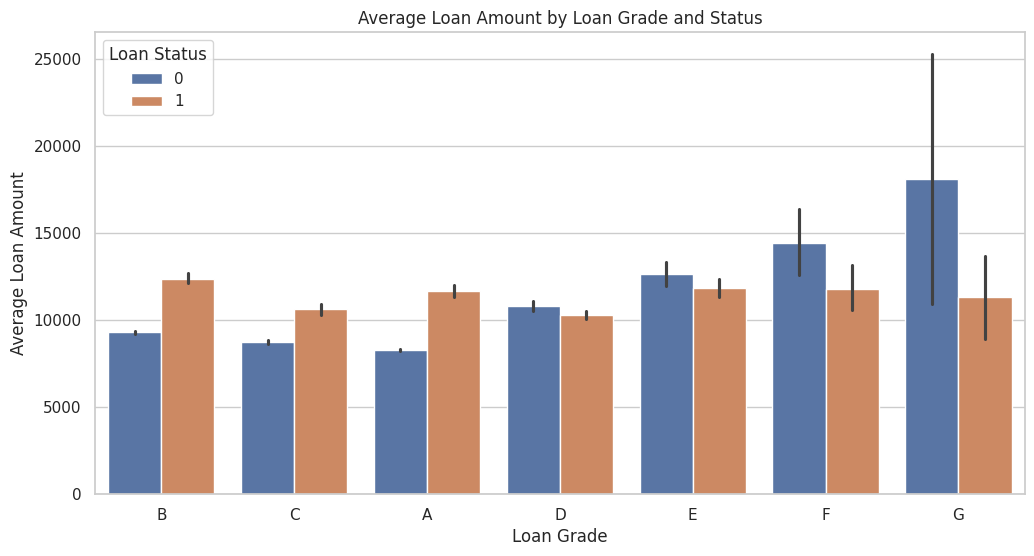

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(x='loan_grade', y='loan_amnt', hue='loan_status', data=df_train, estimator=np.mean)
plt.title('Average Loan Amount by Loan Grade and Status')
plt.xlabel('Loan Grade')
plt.ylabel('Average Loan Amount')
plt.legend(title='Loan Status')
plt.show()

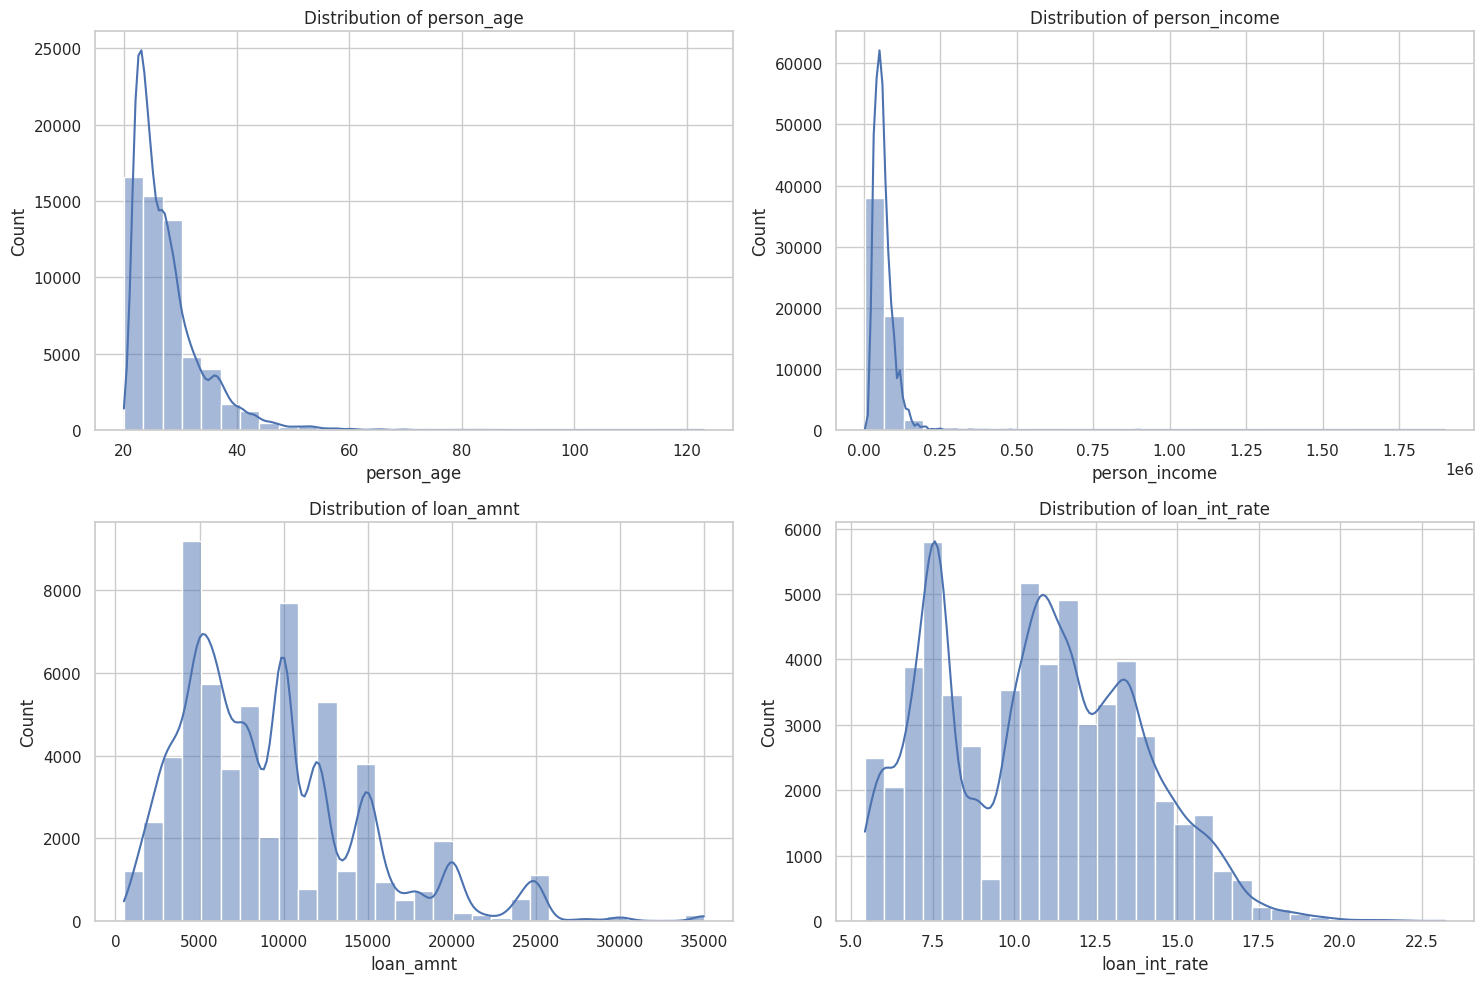

In [19]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_train[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

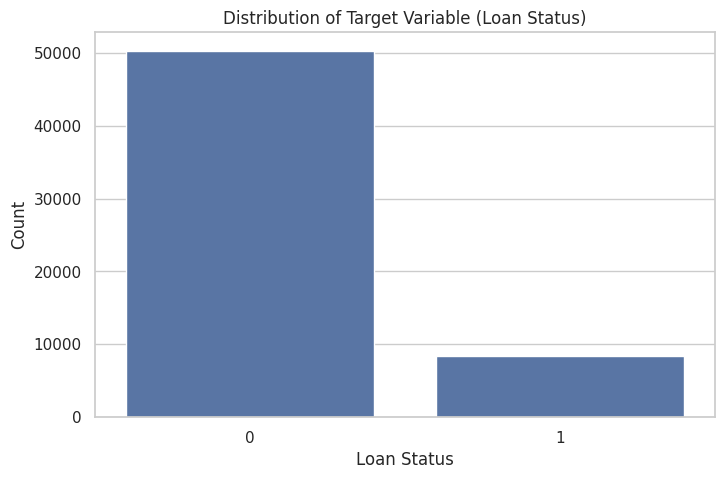

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=df_train)
plt.title('Distribution of Target Variable (Loan Status)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

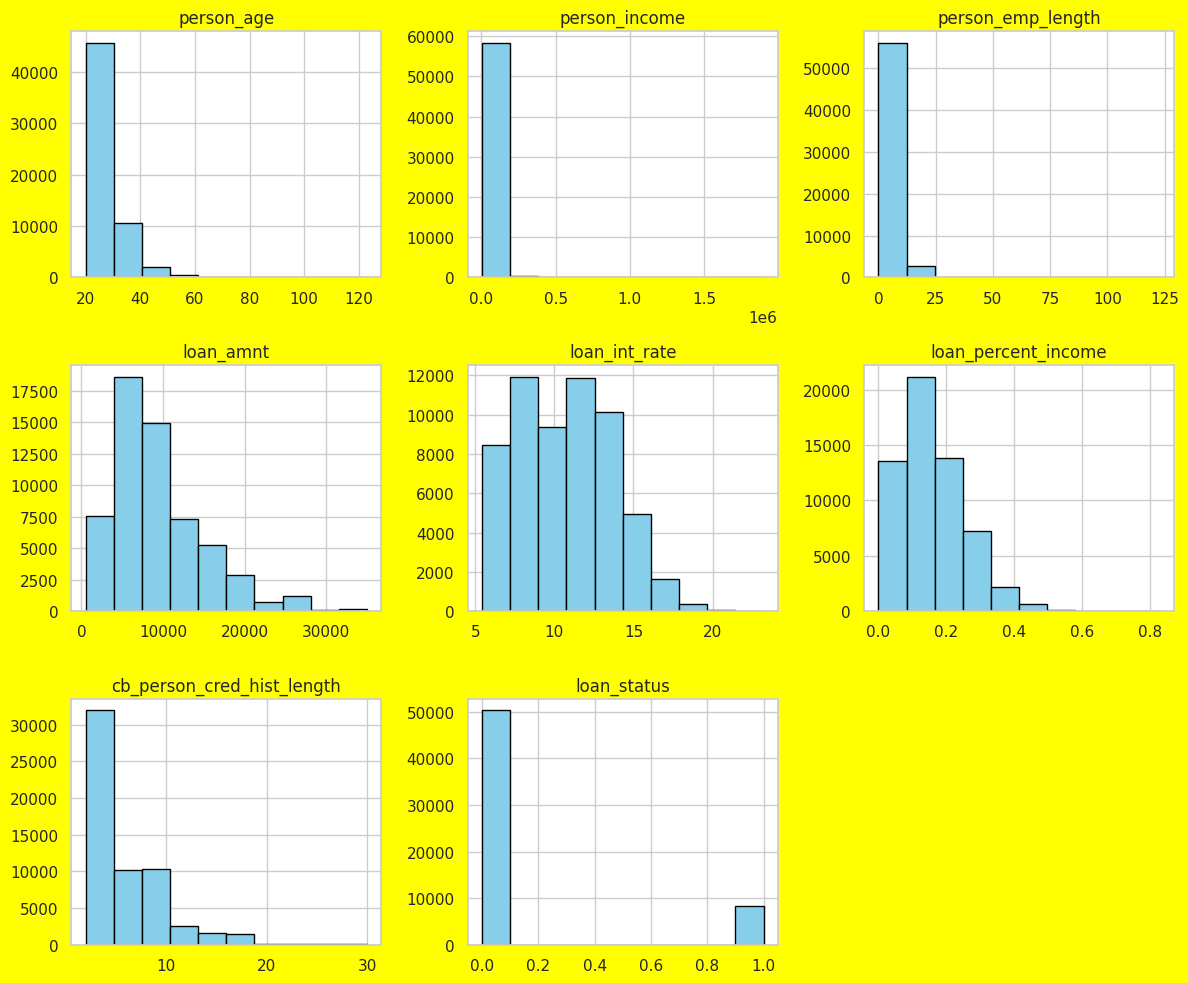

In [21]:
df_train.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.gcf().set_facecolor('yellow')
plt.tight_layout()
plt.show()

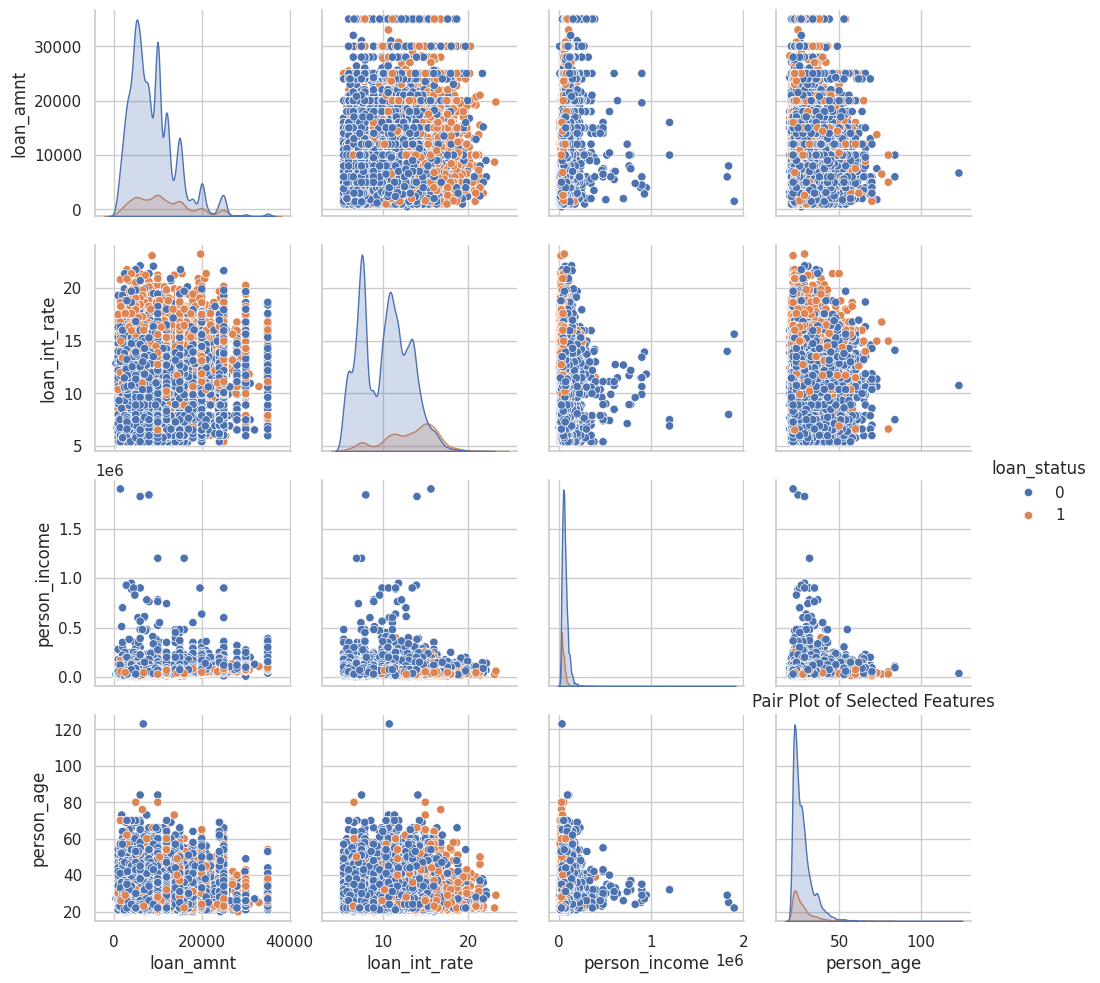

In [22]:
subset_features = ['loan_amnt', 'loan_int_rate', 'person_income', 'person_age', 'loan_status']
sns.pairplot(df_train[subset_features], hue='loan_status')
plt.title('Pair Plot of Selected Features')
plt.show()

In [23]:
%%time

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample = pd.read_csv('/content/sample_submission.csv')
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)


train['person_emp_length'] = pd.to_numeric(train['person_emp_length'], errors='coerce')
train['loan_int_rate'] = pd.to_numeric(train['loan_int_rate'], errors='coerce')

cols_to_impute = ['person_emp_length', 'loan_int_rate']

imputer = SimpleImputer(strategy='median')
imputed_values = imputer.fit_transform(train[cols_to_impute])

imputed_df = pd.DataFrame(imputed_values, columns=cols_to_impute, index=train.index)

train[cols_to_impute] = imputed_df

train = train.drop_duplicates()

cat_c = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def category_c(df):
    global cat_c

    for col in cat_c:

        df[col] = df[col].astype('category')

    return df

train  = category_c(train)
test   = category_c(test)

def New_fe(df):

    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['age_income_interaction'] = df['person_age'] * df['person_income']
    df['loan_int_rate_squared'] = df['loan_int_rate'] ** 2
    df['emp_length_squared'] = df['person_emp_length'] ** 2
    df['loan_amnt_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    df['loan_int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    df['income_percentage_for_loan'] = df['loan_percent_income'] * 100
    df['monthly_income'] = df['person_income'] / 12
    df['monthly_debt'] = (df['loan_amnt'] + df['loan_int_rate'])
    df['debt_to_income'] = df['monthly_debt'] / df['monthly_income']

    return df

train = New_fe(train)
test = New_fe(test)

CPU times: user 225 ms, sys: 15.9 ms, total: 241 ms
Wall time: 241 ms


In [24]:
%%time

def encode_Label(train_df, test_df):
    le_home_ownership = LabelEncoder()
    le_loan_intent = LabelEncoder()
    le_loan_grade = LabelEncoder()
    le_default_on_file = LabelEncoder()

    train_df['person_home_ownership'] = le_home_ownership.fit_transform(train_df['person_home_ownership'])
    train_df['loan_intent'] = le_loan_intent.fit_transform(train_df['loan_intent'])
    train_df['loan_grade'] = le_loan_grade.fit_transform(train_df['loan_grade'])
    train_df['cb_person_default_on_file'] = le_default_on_file.fit_transform(train_df['cb_person_default_on_file'])

    test_df['person_home_ownership'] = le_home_ownership.transform(test_df['person_home_ownership'])
    test_df['loan_intent'] = le_loan_intent.transform(test_df['loan_intent'])
    test_df['loan_grade'] = le_loan_grade.transform(test_df['loan_grade'])
    test_df['cb_person_default_on_file'] = le_default_on_file.transform(test_df['cb_person_default_on_file'])

    return train_df, test_df

train, test = encode_Label(train, test)
train = train.reset_index(drop=True)
random_row = train.sample(n=1)
train = train.drop(random_row.index)

CPU times: user 85.8 ms, sys: 7.1 ms, total: 92.9 ms
Wall time: 98.7 ms


In [25]:
%%time

# Separating features and target variable from the training data
X = train.drop('loan_status', axis=1)
y = train['loan_status']

# SEED and trails
SEED = 42
n_splits = 5

# Getting the column names for both training and test data
feature_columns = X.columns.values

# Converting all feature columns to string datatype for consistency
test[feature_columns] = test[feature_columns].astype(str)
X[feature_columns] = X[feature_columns].astype(str)

def modelBuild(model_template, test_data):

    # Initialize StratifiedKFold with shuffling
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    # Lists to store AUC scores for each fold
    train_auc_scores = []
    val_auc_scores = []

    # Array to store test predictions
    test_predictions = np.zeros((len(test_data), n_splits))

    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Clone the provided model template to avoid data leakage between folds
        model = clone(model_template)

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Get predicted probabilities for training and validation data
        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_val_pred = model.predict_proba(X_val)[:, 1]

        # Calculate AUC for training and validation data
        train_auc = roc_auc_score(y_train, y_train_pred)
        val_auc = roc_auc_score(y_val, y_val_pred)

        train_auc_scores.append(train_auc)
        val_auc_scores.append(val_auc)

        # Store test predictions for this fold
        test_predictions[:, fold] = model.predict_proba(test_data)[:, 1]

        # Display AUC scores for the current fold
        print(f"Fold {fold+1} - Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")

    # Display overall average AUC score across all folds
    print(f"Overall Train AUC: {np.mean(train_auc_scores):.4f}")
    print(f"Overall Val AUC: {np.mean(val_auc_scores):.4f}")

    # Calculate the mean of test predictions across all folds
    mean_test_preds = np.mean(test_predictions, axis=1)

    # Create a submission DataFrame
    submission = pd.DataFrame({
        'id': sample['id'],
        'loan_status': mean_test_preds
    })

    return submission

CPU times: user 1.64 s, sys: 239 ms, total: 1.88 s
Wall time: 2.46 s


In [26]:
%%time

params = {
    'depth': 8,
    'learning_rate': 0.19793301995319765,
    'bagging_temperature': 0.7779373495258176,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'iterations': 300,
    'grow_policy': 'Lossguide',
    'eval_metric': 'AUC',
}

model = CatBoostClassifier(**params, random_seed=SEED, verbose=0,
                                  cat_features=X.columns.values)
submission = modelBuild(model, test)

Fold 1 - Train AUC: 0.9744, Val AUC: 0.9548
Fold 2 - Train AUC: 0.9773, Val AUC: 0.9650
Fold 3 - Train AUC: 0.9809, Val AUC: 0.9608
Fold 4 - Train AUC: 0.9730, Val AUC: 0.9632
Fold 5 - Train AUC: 0.9792, Val AUC: 0.9597
Overall Train AUC: 0.9770
Overall Val AUC: 0.9607
CPU times: user 5min 5s, sys: 8 s, total: 5min 13s
Wall time: 3min 13s


In [27]:
submission.to_csv('submission.csv', index=False)

submission.head()

,id,loan_status
0,58645,0.995465
1,58646,0.010444
2,58647,0.533480
3,58648,0.006595
4,58649,0.027594


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loan_status'].plot(kind='hist', bins=20, title='loan_status')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='loan_status', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['loan_status']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('loan_status')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['loan_status'].plot(kind='line', figsize=(8, 4), title='loan_status')
plt.gca().spines[['top', 'right']].set_visible(False)